<a href="https://colab.research.google.com/github/amitpanwarIndia/DLOps/blob/main/M22AIE202_DLOps_Assignment_Q2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2024-03-17 12:39:04--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.172.170.43, 18.172.170.8, 18.172.170.106, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.172.170.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   196MB/s    in 0.2s    

2024-03-17 12:39:04 (196 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data

Epoch [1/10], Loss: 0.0369
Epoch [2/10], Loss: 0.0144
Epoch [3/10], Loss: 0.0134
Epoch [4/10], Loss: 0.0128
Epoch [5/10], Loss: 0.0117
Epoch [6/10], Loss: 0.0112
Epoch [7/10], Loss: 0.0112
Epoch [8/10], Loss: 0.0107
Epoch [9/10], Loss: 0.0102
Epoch [10/10], Loss: 0.0097


<ipython-input-2-fba535e8a05c>:95: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score += ssim(images[i].cpu().numpy().transpose((1, 2, 0)),


MSE: 0.0083, SSIM: 0.9127


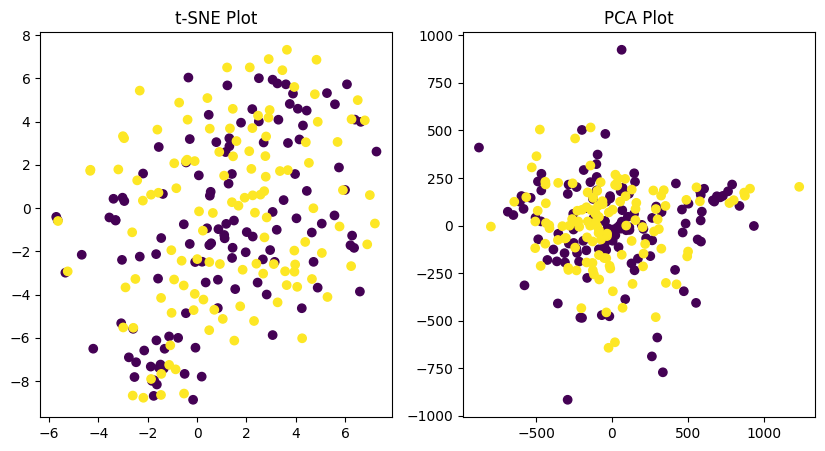

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import log10
from torch.utils.tensorboard import SummaryWriter

# Define a custom transformation to convert RGB images to negative images
class ToNegative(object):
    def __call__(self, image):
        return 1 - image

# Define the Convolutional Autoencoder (CAE) architecture
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()  # Ensure output is in range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define custom dataset and data loading
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    ToNegative()  # Apply the custom transformation to convert images to negative
])

train_dataset = datasets.ImageFolder(root='hymenoptera_data/train', transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(root='hymenoptera_data/val', transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize CAE model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cae_model = CAE().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cae_model.parameters(), lr=0.001)

# Train the CAE model
def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

train_model(cae_model, criterion, optimizer, train_loader, num_epochs=10)

# Evaluation and visualization
def evaluate_model(model, test_loader):
    model.eval()
    mse_loss = 0.0
    ssim_score = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            mse_loss += criterion(outputs, images).item() * images.size(0)
            for i in range(len(images)):
                ssim_score += ssim(images[i].cpu().numpy().transpose((1, 2, 0)),
                                   outputs[i].cpu().numpy().transpose((1, 2, 0)),
                                   multichannel=True)
    mse_loss /= len(test_loader.dataset)
    ssim_score /= len(test_loader.dataset)
    return mse_loss, ssim_score

mse, ssim_score = evaluate_model(cae_model, test_loader)
print(f"MSE: {mse:.4f}, SSIM: {ssim_score:.4f}")

# Feature Visualization with t-SNE and PCA
def extract_features(model, data_loader):
    features = []
    model.eval()
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model.encoder(images)
            features.extend(outputs.cpu().numpy())
    return np.array(features)

train_features = extract_features(cae_model, train_loader)
tsne = TSNE(n_components=2).fit_transform(train_features.reshape(train_features.shape[0], -1))
pca = PCA(n_components=2).fit_transform(train_features.reshape(train_features.shape[0], -1))

# Visualize t-SNE and PCA
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(tsne[:, 0], tsne[:, 1], c=train_dataset.targets)
plt.title('t-SNE Plot')

plt.subplot(1, 2, 2)
plt.scatter(pca[:, 0], pca[:, 1], c=train_dataset.targets)
plt.title('PCA Plot')
plt.show()
